In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\ABHINAV\Desktop\Programming\Projects\iomt-anomalyze\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/raw/wustl_hdrl_2024.csv")

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_29992\4219559405.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/wustl_hdrl_2024.csv")


In [3]:
df.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,sswap_sin,sswap_sout,sdiskusage_total,sdiskusage_used,sdiskusage_free,sdiskusage_percent,Boot_Time_with_date,DTime,Attack_categories,Label
0,->,e,192.168.3.2,192.168.2.2,36390,4022,1651.0,272.0,10440.0,1612.000,...,0,0,502392610816,51814645760,424982593536,10,2023-12-23 15:38:11,104.316401,normal,0
1,->,e,192.168.3.2,192.168.2.2,49608,4022,1673.0,272.0,10576.0,1611.000,...,0,0,502392610816,51814674432,424982564864,10,2023-12-23 15:38:11,104.207156,normal,0
2,->,e,192.168.3.2,192.168.2.2,34596,4022,1650.0,272.0,10364.0,1602.000,...,0,0,502392610816,51814686720,424982552576,10,2023-12-23 15:38:11,104.177347,normal,0
3,->,e d,78.151.208.250,192.168.2.2,18346,4022,1450.0,174.0,0.0,306.469,...,0,0,502392610858,50459127848,426338111537,15,2023-05-09 15:19:38,25.821966,DDoS,1
4,->,e d,143.109.155.233,192.168.2.2,18346,4022,1452.0,174.0,0.0,305.268,...,0,0,502392610863,50459127854,426338111539,15,2023-05-09 15:19:38,25.945508,DDoS,1


In [4]:
non_gen = ["SrcAddr","DstAddr","SrcMac","DstMac","IMEI","Boot_Time_with_date"]

In [5]:
df = df.drop(columns=non_gen)

In [6]:
df

,Dir,Flgs,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,SrcGap,DstGap,...,sswap_percent,sswap_sin,sswap_sout,sdiskusage_total,sdiskusage_used,sdiskusage_free,sdiskusage_percent,DTime,Attack_categories,Label
0,->,e,36390,4022,1651.0,272.0,10440.0,1612.000,0.0,0.0,...,0,0,0,502392610816,51814645760,424982593536,10,104.316401,normal,0
1,->,e,49608,4022,1673.0,272.0,10576.0,1611.000,0.0,0.0,...,0,0,0,502392610816,51814674432,424982564864,10,104.207156,normal,0
2,->,e,34596,4022,1650.0,272.0,10364.0,1602.000,0.0,0.0,...,0,0,0,502392610816,51814686720,424982552576,10,104.177347,normal,0
3,->,e d,18346,4022,1450.0,174.0,0.0,306.469,0.0,0.0,...,0,0,0,502392610858,50459127848,426338111537,15,25.821966,DDoS,1
4,->,e d,18346,4022,1452.0,174.0,0.0,305.268,0.0,0.0,...,0,0,0,502392610863,50459127854,426338111539,15,25.945508,DDoS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145118,->,e d,3617,4022,1453.0,174.0,0.0,307.200,0.0,0.0,...,0,0,0,502392611534,50459128438,426338112161,80,10.176143,DDoS,1
145119,->,e d,3617,4022,1452.0,174.0,0.0,306.281,0.0,0.0,...,0,0,0,502392611536,50459128445,426338112166,80,10.152515,DDoS,1
145120,->,e d,3617,4022,1450.0,174.0,0.0,306.492,0.0,0.0,...,0,0,0,502392611545,50459128446,426338112174,81,10.068303,DDoS,1
145121,->,e,57484,4022,1648.0,272.0,10397.0,1608.000,0.0,0.0,...,0,0,0,30612852736,19991822336,9289617408,68,28.217784,normal,0


In [7]:
encoders = {}

for col in ["Dir","Flgs","Attack_categories","Label"]:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le 

In [8]:
X = df.drop(columns=["Attack_categories", "Label"])   # Label is attack vs benign
y_att = df["Attack_categories"] 
y_bin = df["Label"]  # Binary label: 0 for benign, 1 for attack

In [9]:
y_att.unique()

array([4, 1, 0, 2, 3])

In [10]:
print(dict(zip(encoders["Attack_categories"].classes_, range(len(encoders["Attack_categories"].classes_)))))

{'Buffer_overflow': 0, 'DDoS': 1, 'MiTM': 2, 'Ransomware': 3, 'normal': 4}


In [11]:
print("Attack Categories distribution:")
print(df["Attack_categories"].value_counts())

print("\nBinary Label distribution:")
print(df["Label"].value_counts())

Attack Categories distribution:
Attack_categories
4    132884
1      9971
2      1672
3       528
0        68
Name: count, dtype: int64

Binary Label distribution:
Label
0    132884
1     12239
Name: count, dtype: int64


In [12]:
drop_cols = ["SrcAddr","DstAddr","SrcMac","DstMac","IMEI","RTime","Packet_num"]
X = X.drop(columns=[c for c in drop_cols if c in X.columns])

In [13]:
categorical = ["Dir", "Flgs"]
numeric = [col for col in X.columns if col not in categorical + drop_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

In [14]:
def service_to_port(x):
    try:
        return int(x) if str(x).isdigit() else socket.getservbyname(x)
    except:
        return -1   # unknown service

X["Sport"] = X["Sport"].apply(service_to_port)
X["Dport"] = X["Dport"].apply(service_to_port)

# Attack or Normal Binary Detection:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42, stratify=y_bin)

In [16]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

In [17]:
class_weights_ = dict(zip(classes, class_weights))
class_weights

array([0.54605059, 5.92881217])

In [18]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weights_,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[("preprocess", preprocess), ("clf", rf)])
pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
cat_cols = ["Dir", "Flgs"]   # adjust based on your df
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessor: OHE for categoricals, scale numerics
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Full pipeline
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=4
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", rf)
])

# Fit on training
pipeline.fit(X_train, y_train)

# Predict on test
y_pred = pipeline.predict(X_test)

In [20]:
print("\nClassification Report (Binary IDS):\n")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report (Binary IDS):

              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     26577
           1     0.9959    0.9931    0.9945      2448

    accuracy                         0.9991     29025
   macro avg     0.9976    0.9963    0.9970     29025
weighted avg     0.9991    0.9991    0.9991     29025


Confusion Matrix:
 [[26567    10]
 [   17  2431]]


In [21]:
X_test.shape

(29025, 67)

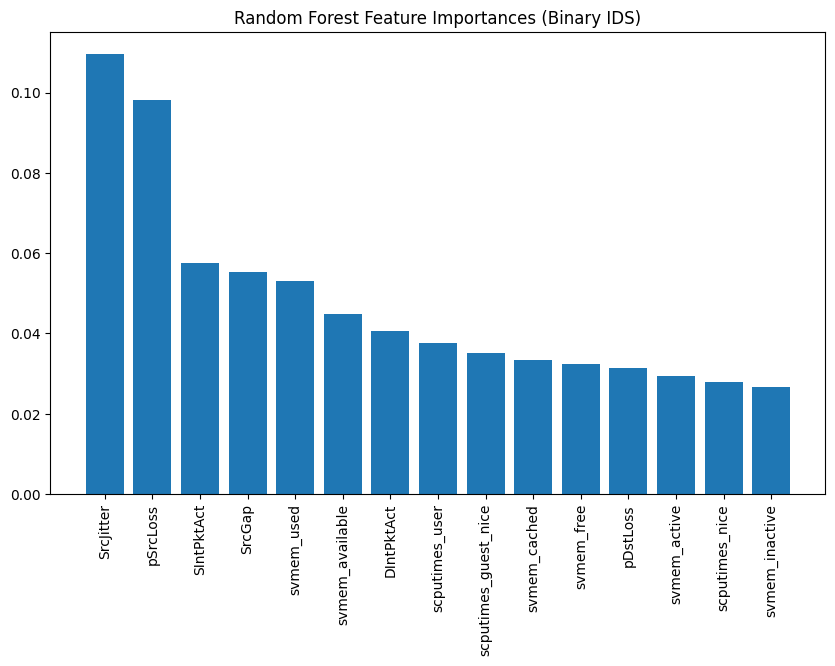

                 Feature  Importance
14             SrcJitter    0.109625
27              pSrcLoss    0.098110
12            SIntPktAct    0.057534
8                 SrcGap    0.055360
47            svmem_used    0.053119
45       svmem_available    0.044887
13            DIntPktAct    0.040556
30        scputimes_user    0.037560
39  scputimes_guest_nice    0.035138
52          svmem_cached    0.033347
48            svmem_free    0.032255
28              pDstLoss    0.031409
49          svmem_active    0.029496
31        scputimes_nice    0.027896
50        svmem_inactive    0.026632


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 15 features for plotting
top_n = 15
plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importances (Binary IDS)")
plt.bar(range(top_n), importances[indices[:top_n]], align='center')

# Handle column name mismatch
feature_names = X_train.columns
if len(importances) > len(feature_names):
    # If importances come from transformed features, just use indices for top_n
    try:
        plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)
    except IndexError:
        plt.xticks(range(top_n), [f"Feature {i}" for i in indices[:top_n]], rotation=90)
else:
    plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)

plt.show()

# Top features DataFrame (safe)
min_len = min(len(feature_names), len(importances))
feat_imp = pd.DataFrame({
    "Feature": feature_names[:min_len],
    "Importance": importances[:min_len]
}).sort_values("Importance", ascending=False)

print(feat_imp.head(top_n))


Extreme Gradient Boosting:

In [24]:
import xgboost as xgb

In [25]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)

In [26]:
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb_clf)
])

In [27]:
xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
y_pred_xgb = xgb_pipeline.predict(X_test)

In [29]:
print("\nClassification Report (Binary IDS):\n")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Classification Report (Binary IDS):

              precision    recall  f1-score   support

           0     0.9994    0.9996    0.9995     26577
           1     0.9959    0.9931    0.9945      2448

    accuracy                         0.9991     29025
   macro avg     0.9976    0.9963    0.9970     29025
weighted avg     0.9991    0.9991    0.9991     29025


Confusion Matrix:
 [[26566    11]
 [   14  2434]]


1D CNN Classifier:

In [30]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [31]:
X_train_transformed = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_test_transformed = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed

In [32]:
#I am reshaping the data 3D for Conv1D: (samples, timesteps, features)
X_train_cnn = np.expand_dims(X_train_transformed, axis=2)
X_test_cnn = np.expand_dims(X_test_transformed, axis=2)

In [33]:
X_train_cnn

array([[[ 1.1166394 ],
        [ 0.        ],
        [-0.31037171],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.6761396 ],
        [ 0.        ],
        [ 1.27956684],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.18484676],
        [ 0.        ],
        [ 1.87651127],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[ 1.35367124],
        [ 0.        ],
        [-0.41368902],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.98592791],
        [ 0.        ],
        [-0.35055066],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.05322744],
        [ 0.        ],
        [-0.43664842],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]], shape=(116098, 74, 1))

1D CNN:

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [36]:
input_shape = (X_train_cnn.shape[1], 1)

In [37]:
oned_cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


c:\Users\ABHINAV\Desktop\Programming\Projects\iomt-anomalyze\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [39]:
oned_cnn_model.compile(
    optimizer='adamw',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [40]:
oned_cnn_model_history = oned_cnn_model.fit(
    X_train_cnn, y_train, 
    epochs = 30, 
    batch_size = 64, 
    validation_split = 0.2,
    verbose = 1,
    class_weight=class_weights
)

Epoch 1/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.9618 - loss: 0.1950 - val_accuracy: 0.9843 - val_loss: 0.0473
Epoch 2/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9823 - loss: 0.0696 - val_accuracy: 0.9896 - val_loss: 0.0373
Epoch 3/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.9864 - loss: 0.0506 - val_accuracy: 0.9772 - val_loss: 0.0676
Epoch 4/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9874 - loss: 0.0455 - val_accuracy: 0.9921 - val_loss: 0.0225
Epoch 5/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9878 - loss: 0.0422 - val_accuracy: 0.7276 - val_loss: 0.6127
Epoch 6/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9889 - loss: 0.0430 - val_accuracy: 0.9837 - val_loss: 0.0582
Epoch 7/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9896 - loss: 0.0400 - val_accuracy: 0.7081 - val_loss: 0.7994
Epoch 8/30
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.9885 -

In [41]:
y_pred_cnn = (oned_cnn_model.predict(X_test_cnn) > 0.5)

908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [42]:
y_pred_cnn

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(29025, 1))

In [43]:
y_pred_cnn = y_pred_cnn.astype(int)

In [44]:
print("1D CNN Results:\n", classification_report(y_test, y_pred_cnn))

1D CNN Results:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     26577
           1       0.86      0.99      0.92      2448

    accuracy                           0.99     29025
   macro avg       0.93      0.99      0.95     29025
weighted avg       0.99      0.99      0.99     29025



Custom RCLNet (not the recurrent conv variant, rather an hybrid):

In [45]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Dropout

In [46]:
X_train_seq = np.expand_dims(X_train_transformed, axis=2)
X_test_seq = np.expand_dims(X_test_transformed, axis=2)

In [47]:
input_shape = (X_train_seq.shape[1], 1)

rcl_hybrid_model = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(2),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

c:\Users\ABHINAV\Desktop\Programming\Projects\iomt-anomalyze\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
rcl_hybrid_model.compile(optimizer='adamw',
              loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [49]:
rcl_hybrid_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 74, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 74, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,633 (147.00 KB)

 Non-trainable params: 128 (512.00 B)

In [50]:
history = rcl_hybrid_model.fit(
    X_train_seq, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    verbose=1, 
    class_weight=class_weights
)

Epoch 1/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 60s 39ms/step - accuracy: 0.9689 - loss: 0.1583 - precision: 0.7660 - recall: 0.9094 - val_accuracy: 0.9723 - val_loss: 0.0624 - val_precision: 0.7579 - val_recall: 0.9857
Epoch 2/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 65s 45ms/step - accuracy: 0.9832 - loss: 0.0535 - precision: 0.8465 - recall: 0.9784 - val_accuracy: 0.9919 - val_loss: 0.0245 - val_precision: 0.9307 - val_recall: 0.9764
Epoch 3/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - accuracy: 0.9870 - loss: 0.0453 - precision: 0.8775 - recall: 0.9835 - val_accuracy: 0.9877 - val_loss: 0.0373 - val_precision: 0.8822 - val_recall: 0.9852
Epoch 4/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 69s 48ms/step - accuracy: 0.9871 - loss: 0.0430 - precision: 0.8774 - recall: 0.9848 - val_accuracy: 0.9895 - val_loss: 0.0359 - val_precision: 0.9040 - val_recall: 0.9790
Epoch 5/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 67s 46ms/step - accuracy: 0.9894 - loss: 0.0396 - precision: 0.9005 - recall: 0.9828 - val_accuracy: 0

In [51]:
y_pred_hybrid = (rcl_hybrid_model.predict(X_test_seq) > 0.5)

908/908 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step


In [52]:
print("Hybrid RCL Results:\n", classification_report(y_test, y_pred_hybrid))

Hybrid RCL Results:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     26577
           1       0.94      0.99      0.97      2448

    accuracy                           0.99     29025
   macro avg       0.97      0.99      0.98     29025
weighted avg       0.99      0.99      0.99     29025



RCLHybrid with self-attention:

In [53]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Dropout, Multiply, Permute, Lambda
import tensorflow.keras.backend as K

In [54]:
def attention_block(inputs):
    # Compute attention scores
    attention = Dense(1, activation='tanh')(inputs)
    attention = Lambda(lambda x: K.softmax(x, axis=1))(attention)
    # Weighted sum
    outputs = Multiply()([inputs, attention])
    outputs = Lambda(lambda x: K.sum(x, axis=1))(outputs)
    return outputs

In [55]:
inputs = Input(shape=(X_train_seq.shape[1], 1))
x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = LSTM(64, return_sequences=True)(x)
x = attention_block(x) 
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

In [56]:
hybrid_attention_model = Model(inputs, outputs)
hybrid_attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

hybrid_attention_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 74, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 74, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 37, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 37, 64)    │     33,024 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 37, 1)     │         65 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 37, 1)     │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 37, 64)    │          0 │ lstm_1[0][0],     │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,826 (147.76 KB)

 Trainable params: 37,698 (147.26 KB)

 Non-trainable params: 128 (512.00 B)

In [57]:
history_att = hybrid_attention_model.fit(
    X_train_seq, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 86s 50ms/step - accuracy: 0.9884 - loss: 0.0436 - precision: 0.9592 - recall: 0.9004 - val_accuracy: 0.9940 - val_loss: 0.0207 - val_precision: 0.9704 - val_recall: 0.9580
Epoch 2/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - accuracy: 0.9941 - loss: 0.0195 - precision: 0.9692 - recall: 0.9601 - val_accuracy: 0.9944 - val_loss: 0.0179 - val_precision: 0.9750 - val_recall: 0.9575
Epoch 3/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.9949 - loss: 0.0174 - precision: 0.9777 - recall: 0.9612 - val_accuracy: 0.9944 - val_loss: 0.0161 - val_precision: 0.9735 - val_recall: 0.9601
Epoch 4/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.9949 - loss: 0.0169 - precision: 0.9774 - recall: 0.9622 - val_accuracy: 0.9947 - val_loss: 0.0168 - val_precision: 0.9721 - val_recall: 0.9642
Epoch 5/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - accuracy: 0.9951 - loss: 0.0160 - precision: 0.9772 - recall: 0.9644 - val_accuracy: 0